In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 1,
      'axes.labelpad': 6,
      'xtick.major.pad': 10,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 12,
      'axes.titlesize': 12,
      'axes.labelsize': 12,
      'xtick.labelsize': 12,
      'ytick.labelsize': 12,
      'legend.title_fontsize': 11,
      'legend.fontsize': 11,
      'figure.titlesize': 12,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

In [35]:
prf_df = pd.DataFrame({})
subj_list = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']
roi_list = ['V1', 'V2', 'V3']
for subj, roi in itertools.product(subj_list, roi_list):
    df = pd.read_csv(f'/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/model/dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFcenter_tavg-True.csv')
    df.drop_duplicates(subset=['voxel'], inplace=True)
    df = df[['sub', 'vroinames', 'voxel', 'eccentricity', 'angle', 'size','R2']]
    prf_df = pd.concat([prf_df, df])

In [75]:
e1, e2=0.5, 4
enum=7
enum_range=range(3) if enum=='log3' else range(enum)
prf_df = prf_df.query('R2 > 40')
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
prf_df['ecc_bin'] = tuning.bin_ecc(prf_df['eccentricity'], bin_list, bin_labels)
prf_bin_df = tuning.summary_stat_for_ecc_bin(prf_df,
                                       to_group=['sub','vroinames','ecc_bin'],
                                       to_bin=['size'],
                                       central_tendency='median')


In [76]:
prf_bin_df['ecc'] = prf_bin_df.apply(vis1D._get_middle_ecc, axis=1)
prf_coeff_df = prf_bin_df.groupby(['sub','vroinames']).apply(lambda x: np.polyfit(x['ecc'], x['size'], 1))
prf_coeff_df = prf_coeff_df.reset_index().rename(columns={0: 'coefficient'})
prf_fit_df = pd.merge(prf_bin_df, prf_coeff_df, on=['sub','vroinames'])
prf_fit_df = vis1D._add_ecc_0(prf_fit_df, groupby=['sub','vroinames'])
prf_fit_df['fitted'] = prf_fit_df.apply(lambda x: x['coefficient'][0] * x['ecc'] + x['coefficient'][1], axis=1)

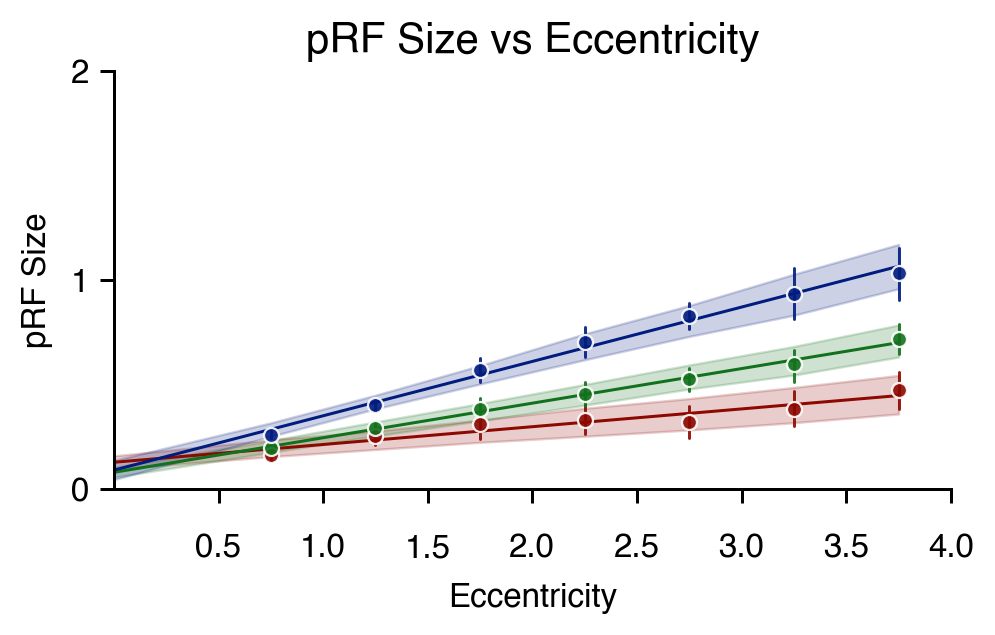

In [77]:
a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
#roi_pal.insert(0, (0.5,0.5,0.5))

# Usage Example
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
vis1D.plot_prf_size_vs_eccentricity(prf_fit_df, 'ecc', 'fitted', 'vroinames', ax=ax, hue_order=['V1','V2','V3'], pal=roi_pal)
plt.show()


In [23]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures', 'sfp_model', 'results_1D')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'
max_epoch=8000
lr=0.005

a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))

# NSD data
f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_sub-{subj}_roi-{roi}_vs-pRFcenter.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))
nsd_subj_df = utils.load_dataframes(f)
nsd_subj_df = nsd_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
# NSD fitting results
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(subj_list, roi_list, enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj}_roi-{roi}_vs-pRFcenter.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn',  file_name))
nsd_tuning_df = tuning.load_all_models(pt_file_list, *args)

# NSD precision data
file_list = []
for subj, roi in itertools.product(subj_list, roi_list):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

nsd_tuning_with_precision_df = nsd_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
nsd_tuning_with_precision_df['pp'] = 1/ nsd_tuning_with_precision_df['mode']
nsd_fit_df = vis1D.fit_line_to_weighted_mean(nsd_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])
nsd_tuning_with_precision_df['fwhm'] = nsd_tuning_with_precision_df['sigma']*2.335

In [90]:
all_df = pd.merge(prf_fit_df, nsd_tuning_with_precision_df, on=['sub', 'vroinames','ecc_bin','ecc'])

In [91]:
all_df.columns

Index(['sub', 'vroinames', 'ecc_bin', 'size', 'ecc', 'coefficient', 'fitted',
       'slope', 'mode', 'sigma', 'names', 'lr_rate', 'max_epoch', 'e1', 'e2',
       'nbin', 'curbin', 'precision', 'pp', 'fwhm'],
      dtype='object')

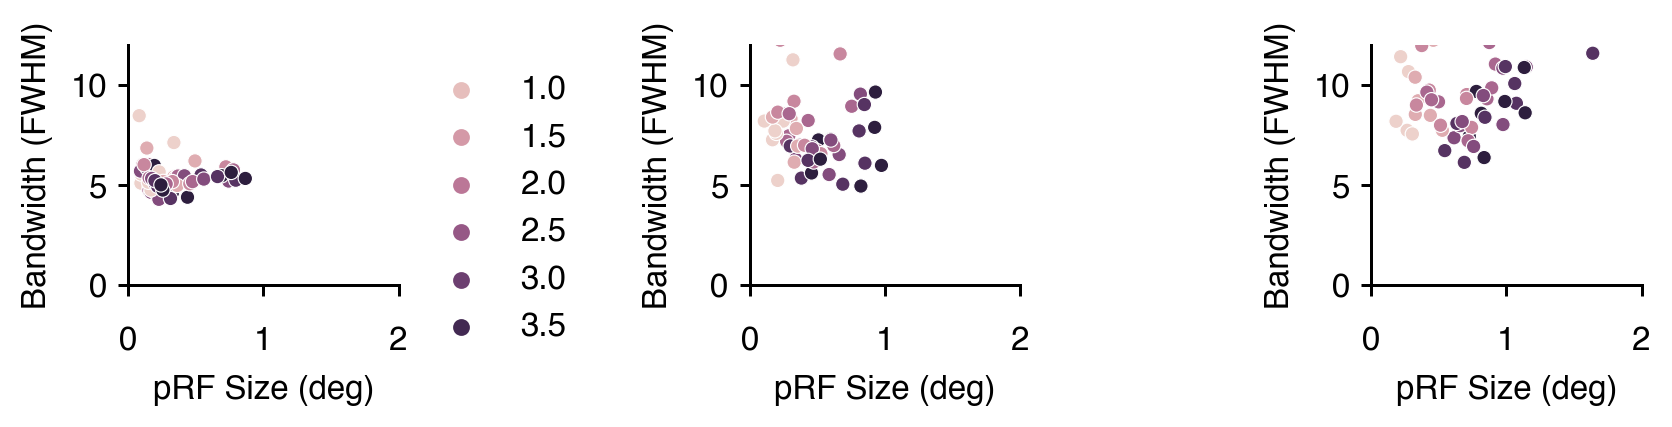

In [102]:
fig, ax = plt.subplots(1,3, figsize=(8,2))

for i, ax in enumerate(ax):
    roi = roi_list[i]
    ax = vis1D.plot_prf_size_vs_fwhm(all_df.query('vroinames == @roi'), 
                                 'size', 'fwhm', 'ecc', ax=ax, pal=None)
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1)) if i == 0 else ax.get_legend().remove()
fig.tight_layout()

Text(0.5, 1.0, 'pRF Size vs Bandwidth (FWHM)')

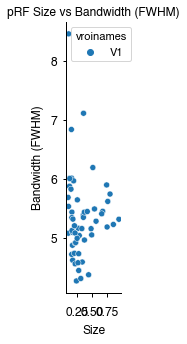

In [32]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = sns.scatterplot(data=all_df, x='size', y='fwhm', hue='vroinames', ax=ax)

ax.set_aspect('equal')
ax.set_xlabel('Size')
ax.set_ylabel('Bandwidth (FWHM)')
ax.set_title('pRF Size vs Bandwidth (FWHM)')